In [0]:
#train.csv - id, tweet_text, labels one hot encoded
#test.csv - id, tweet_text
#test_labels.csv - id, labels one hot encoded -- of test texts

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive/My Drive/EmotionDetection/Classification_system/

/content/drive/My Drive/EmotionDetection/Classification_system


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers, Model
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, SpatialDropout1D, LSTM, Bidirectional, TimeDistributed, Input
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

sns.set_style("whitegrid")
#np.random.seed(0)

#DATA_PATH = ''
#EMBEDDING_DIR = ''

MAX_NB_WORDS = 200000
tokenizer = RegexpTokenizer(r'\w+')
#stop_words = set(stopwords.words('english'))
#stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Let's load the data and the embeddings...

In [0]:
#load embeddings
#print('loading word embeddings...')
#embeddings_index = {}
#f = codecs.open('../input/fasttext/wiki.simple.vec', encoding='utf-8')
#for line in tqdm(f):
#    values = line.rstrip().rsplit(' ')
#    word = values[0]
#    coefs = np.asarray(values[1:], dtype='float32')
#    embeddings_index[word] = coefs
#f.close()
#print('found %s word vectors' % len(embeddings_index))

In [0]:
from gensim.models import FastText
embeddings_index = FastText.load("../Embeddings/hinglish_plus_english_fasttext_stopwords_present_rarewords_absent.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from gensim.models import Word2Vec
embeddings_index = Word2Vec.load("../Embeddings/hinglish_plus_english_word2vec_stopwords_present_rarewords_absent.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


num train:  149088
num test:  149088
24


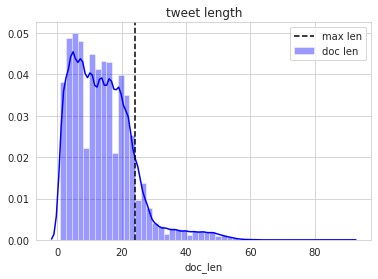

In [0]:
#load data

train_df = pd.read_csv('../Dataset/all_tweets_processed.csv', sep=',', header=0, encoding='ISO-8859-1')
test_df = pd.read_csv('../Dataset/all_tweets_processed.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])
#print(test_df)
#label_names = ["sarcastic", "not_sarcastic"]
label_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

y_train = train_df[label_names].values
y_test = test_df[label_names].values
#y_train=y_train[0:4999]
#y_test=y_train[:251]
#print(len(y_train))
#print(len(y_test))
#visualize word distribution
train_df['doc_len'] = train_df['tweet_text'].astype(str).apply(lambda words: len(words.split(" ")))
#test_df['doc_len'] = test_df['tweet_text'].astype(str).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
#max_seq_len = train_df['doc_len'].max()
print(max_seq_len)
sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); 
plt.legend()
plt.show()

Let's pre-process the text, tokenize it and pad it to a maximum length (as in the figure above).

In [0]:
processed_docs_train = train_df['tweet_text'].astype(str).tolist()
processed_docs_test = test_df['tweet_text'].astype(str).tolist() 
num_classes = len(label_names)

#raw_docs_train = train_df['tweet_text'].tolist()
#raw_docs_test = test_df['tweet_text'].tolist() 

#print(processed_docs_train)

#print("pre-processing train data...")
#processed_docs_train = []
#for doc in tqdm(raw_docs_train):
#    tokens = tokenizer.tokenize(str(doc))
#    filtered = [word for word in tokens if word not in stop_words]
#    filtered = [word for word in tokens]
#    processed_docs_train.append(" ".join(filtered))

#print(processed_docs_train)
#end for

#processed_docs_test = []
#for doc in tqdm(raw_docs_test):
#    tokens = tokenizer.tokenize(doc)
#    #filtered = [word for word in tokens if word not in stop_words]
#    filtered = [word for word in tokens]
#    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
total_docs=[]
total_docs.extend(processed_docs_train)
total_docs.extend(processed_docs_test)
#tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
tokenizer.fit_on_texts(total_docs)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
#print(word_seq_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print(len(word_index))
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
print(word_seq_train[2])
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

tokenizing input data...
15036
dictionary size:  15036
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 3034 1211   12 1211   63 2702    1]


We can now prepare our embedding matrix limiting to a max number of words:

In [0]:
#training params
batch_size = 64
num_epochs = 8 

#model parameters
num_filters = 128 
num_kernels=200
stride=1
embed_dim = 300
weight_decay = 1e-4

#parallel layers 
kernel_size=7
kernel_size_p1=3
kernel_size_p2=6
kernel_size_p3=9
kernel_size_p4=12

In [0]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    #print(word)

    if embeddings_index.wv.__contains__(word): 

        embedding_vector = embeddings_index.wv[word]
    
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
#print(embedding_matrix)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [0]:
print(len(embedding_matrix[34]))

300


In [0]:
print(words_not_found)
#print(embeddings_index.wv.__contains__("abe"))
#print(embeddings_index.wv['ddlj'])
#print(len(words_not_found))
#print(len(embedding_matrix))
#print(len(word_index))


['d3']


It's interesting to look at the words not found in the embeddings:

In [0]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['msguy90' 'dinusirvi' 'suvaro' "gaal'" 'ranbhoomi' 'pradesiya' 'ujarey'
 '681819043007836160\xa0\x85' 'journojuno' '2semi']


Let's define our training and model parameters:

We can finally define the CNN architecture

In [0]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_kernels, kernel_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_kernels, kernel_size, activation='relu', padding='same'))
#model.add(GlobalMaxPooling1D())
model.add(MaxPooling1D(2))
#model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)
model.add(Dense(num_classes, activation='sigmoid')) 

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 300)           4510800   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 24, 200)           420200    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 12, 200)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 12, 200)           280200    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 6, 200)            0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2

In [0]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True)

Train on 134179 samples, validate on 14909 samples
Epoch 1/20
134179/134179 [==============================] - 14s 105us/step - loss: 1.3792 - accuracy: 0.4575 - val_loss: 1.2005 - val_accuracy: 0.5503
Epoch 2/20
134179/134179 [==============================] - 14s 104us/step - loss: 1.1912 - accuracy: 0.5519 - val_loss: 1.1353 - val_accuracy: 0.5793
Epoch 3/20
134179/134179 [==============================] - 14s 102us/step - loss: 1.1234 - accuracy: 0.5818 - val_loss: 1.1003 - val_accuracy: 0.5970
Epoch 4/20
134179/134179 [==============================] - 14s 104us/step - loss: 1.0736 - accuracy: 0.6028 - val_loss: 1.0841 - val_accuracy: 0.6008
Epoch 5/20
134179/134179 [==============================] - 14s 108us/step - loss: 1.0360 - accuracy: 0.6200 - val_loss: 1.0685 - val_accuracy: 0.6086
Epoch 6/20
134179/134179 [==============================] - 15s 108us/step - loss: 1.0030 - accuracy: 0.6344 - val_loss: 1.0603 - val_accuracy: 0.6147
Epoch 7/20
134179/134179 [=================

In [0]:
print("training CNN2 ...")

inputt = Input(shape=(max_seq_len,))
model = Embedding(nb_words, embed_dim,weights=[embedding_matrix],input_length=max_seq_len, trainable = False)(inputt)
tower_1 = Conv1D(num_kernels, kernel_size_p1, padding='same', activation='relu', strides=stride)(model)
tower_2 = Conv1D(num_kernels, kernel_size_p2, padding='same', activation='relu', strides=stride)(model)
tower_3 = Conv1D(num_kernels, kernel_size_p3, padding='same', activation='relu', strides=stride)(model)
tower_4 = Conv1D(num_kernels, kernel_size_p4, padding='same', activation='relu', strides=stride)(model)
model = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis=1)
model = GlobalMaxPooling1D()(model)
model = Dropout(0.5)(model)
#model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dense(64, activation='relu')(model)
output = Dense(num_classes, activation='sigmoid')(model)
model = Model(inputt, output)

#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


training CNN2 ...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 24, 300)      4510800     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 24, 200)      180200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 24, 200)      360200      embedding_1[0][0]                
__________________________________________________________________________

In [0]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True)

Train on 134179 samples, validate on 14909 samples
Epoch 1/8
134179/134179 [==============================] - 45s 333us/step - loss: 1.7860 - accuracy: 0.2035 - val_loss: 1.7680 - val_accuracy: 0.1826
Epoch 2/8
134179/134179 [==============================] - 38s 283us/step - loss: 1.5490 - accuracy: 0.3549 - val_loss: 1.3263 - val_accuracy: 0.4834
Epoch 3/8
134179/134179 [==============================] - 38s 281us/step - loss: 1.3280 - accuracy: 0.4862 - val_loss: 1.2361 - val_accuracy: 0.5348
Epoch 4/8
134179/134179 [==============================] - 38s 283us/step - loss: 1.2424 - accuracy: 0.5287 - val_loss: 1.1813 - val_accuracy: 0.5621
Epoch 5/8
134179/134179 [==============================] - 38s 284us/step - loss: 1.1901 - accuracy: 0.5520 - val_loss: 1.1403 - val_accuracy: 0.5806
Epoch 6/8
134179/134179 [==============================] - 38s 281us/step - loss: 1.1474 - accuracy: 0.5720 - val_loss: 1.1076 - val_accuracy: 0.5892
Epoch 7/8
134179/134179 [========================

In [0]:
#LSTM Params

lstm_out1 = 150
bilstm_out1 = 96
lstm_out2 = 32
dropout = 0.2
recurrent_dropout = 0.2

In [0]:
#LSTM

model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(LSTM(lstm_out1, dropout_U = 0.2, dropout_W = 0.2))
#model.add(MaxPooling1D(2))
model.add(Dense(64, activation='relu'))

model.add(Dense(num_classes, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(150, dropout=0.2, recurrent_dropout=0.2)`
  """


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 300)           4510800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                9664      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 4,791,454
Trainable params: 280,654
Non-trainable params: 4,510,800
_________________________________________________________________


In [13]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True)

Train on 134179 samples, validate on 14909 samples
Epoch 1/8
134179/134179 [==============================] - 165s 1ms/step - loss: 1.2247 - accuracy: 0.5355 - val_loss: 1.0920 - val_accuracy: 0.5982
Epoch 2/8
134179/134179 [==============================] - 167s 1ms/step - loss: 1.0764 - accuracy: 0.5982 - val_loss: 1.0434 - val_accuracy: 0.6137
Epoch 3/8
134179/134179 [==============================] - 165s 1ms/step - loss: 1.0242 - accuracy: 0.6202 - val_loss: 1.0157 - val_accuracy: 0.6251
Epoch 4/8
134179/134179 [==============================] - 164s 1ms/step - loss: 0.9881 - accuracy: 0.6353 - val_loss: 1.0064 - val_accuracy: 0.6289
Epoch 5/8
134179/134179 [==============================] - 163s 1ms/step - loss: 0.9609 - accuracy: 0.6456 - val_loss: 0.9890 - val_accuracy: 0.6390
Epoch 6/8
134179/134179 [==============================] - 164s 1ms/step - loss: 0.9389 - accuracy: 0.6547 - val_loss: 0.9920 - val_accuracy: 0.6399
Epoch 7/8
134179/134179 [==============================

In [14]:
# BiLSTM

# main model
inputt = Input(shape=(max_seq_len,))
model = Embedding(nb_words, embed_dim,weights=[embedding_matrix],input_length=max_seq_len, trainable = False)(inputt)
model =  Bidirectional (LSTM (lstm_out1, return_sequences=True, dropout_U = 0.2, dropout_W = 0.2 ), merge_mode='concat')(model)
model = TimeDistributed(Dense(10,activation='relu'))(model)
model = Flatten()(model)
model = Dense(64,activation='relu')(model)
output = Dense(num_classes,activation='sigmoid')(model)
model = Model(inputt,output)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(150, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 24)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 24, 300)           4510800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 24, 300)           541200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 10)            3010      
_________________________________________________________________
flatten_1 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                15424     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390 

In [15]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True)

Train on 134179 samples, validate on 14909 samples
Epoch 1/8
134179/134179 [==============================] - 306s 2ms/step - loss: 1.2002 - accuracy: 0.5453 - val_loss: 1.0537 - val_accuracy: 0.6122
Epoch 2/8
134179/134179 [==============================] - 304s 2ms/step - loss: 1.0268 - accuracy: 0.6219 - val_loss: 0.9941 - val_accuracy: 0.6383
Epoch 3/8
134179/134179 [==============================] - 305s 2ms/step - loss: 0.9566 - accuracy: 0.6503 - val_loss: 0.9670 - val_accuracy: 0.6501
Epoch 4/8
134179/134179 [==============================] - 304s 2ms/step - loss: 0.9097 - accuracy: 0.6695 - val_loss: 0.9504 - val_accuracy: 0.6570
Epoch 5/8
134179/134179 [==============================] - 301s 2ms/step - loss: 0.8727 - accuracy: 0.6847 - val_loss: 0.9444 - val_accuracy: 0.6625
Epoch 6/8
134179/134179 [==============================] - 302s 2ms/step - loss: 0.8439 - accuracy: 0.6952 - val_loss: 0.9277 - val_accuracy: 0.6683
Epoch 7/8
134179/134179 [==============================

In [0]:
# Attention BiLSTM

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight( shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        #print(self.name)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [17]:
inp = Input(shape=(max_seq_len, ))
x = Embedding(nb_words, embed_dim, weights=[embedding_matrix],
                  trainable=False)(inp)
x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.25,
                          recurrent_dropout=0.25))(x)
x = Attention(max_seq_len)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(num_classes, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 24)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 24, 300)           4510800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 24, 600)           1442400   
_________________________________________________________________
attention_1 (Attention)      (None, 600)               624       
_________________________________________________________________
dense_9 (Dense)              (None, 256)               153856    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 1542

In [18]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True)

Train on 134179 samples, validate on 14909 samples
Epoch 1/8
134179/134179 [==============================] - 365s 3ms/step - loss: 1.1726 - accuracy: 0.5582 - val_loss: 1.0160 - val_accuracy: 0.6255
Epoch 2/8
134179/134179 [==============================] - 363s 3ms/step - loss: 0.9988 - accuracy: 0.6333 - val_loss: 0.9496 - val_accuracy: 0.6569
Epoch 3/8
134179/134179 [==============================] - 366s 3ms/step - loss: 0.9234 - accuracy: 0.6636 - val_loss: 0.9144 - val_accuracy: 0.6720
Epoch 4/8
134179/134179 [==============================] - 367s 3ms/step - loss: 0.8695 - accuracy: 0.6846 - val_loss: 0.8943 - val_accuracy: 0.6778
Epoch 5/8
134179/134179 [==============================] - 366s 3ms/step - loss: 0.8276 - accuracy: 0.7010 - val_loss: 0.8783 - val_accuracy: 0.6865
Epoch 6/8
134179/134179 [==============================] - 367s 3ms/step - loss: 0.7915 - accuracy: 0.7136 - val_loss: 0.8857 - val_accuracy: 0.6860
Epoch 7/8
134179/134179 [==============================

In [0]:
inp = Input(shape=(max_seq_len, ))
x = Embedding(nb_words, embed_dim, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(LSTM(lstm_out1 , return_sequences=True, dropout=0.25, recurrent_dropout=0.25))(x)
x = Attention(max_seq_len)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(num_classes, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 24)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 24, 300)           4510800   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 24, 300)           541200    
_________________________________________________________________
attention_7 (Attention)      (None, 300)               324       
_________________________________________________________________
dense_13 (Dense)             (None, 256)               77056     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 1542

In [0]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True)

Train on 134179 samples, validate on 14909 samples
Epoch 1/8
134179/134179 [==============================] - 199s 1ms/step - loss: 1.1853 - accuracy: 0.5511 - val_loss: 1.0387 - val_accuracy: 0.6147
Epoch 2/8
134179/134179 [==============================] - 201s 1ms/step - loss: 1.0230 - accuracy: 0.6229 - val_loss: 0.9742 - val_accuracy: 0.6432
Epoch 3/8
134179/134179 [==============================] - 202s 2ms/step - loss: 0.9578 - accuracy: 0.6495 - val_loss: 0.9315 - val_accuracy: 0.6637
Epoch 4/8
134179/134179 [==============================] - 203s 2ms/step - loss: 0.9125 - accuracy: 0.6671 - val_loss: 0.9211 - val_accuracy: 0.6677
Epoch 5/8
134179/134179 [==============================] - 202s 2ms/step - loss: 0.8803 - accuracy: 0.6811 - val_loss: 0.9102 - val_accuracy: 0.6702
Epoch 6/8
134179/134179 [==============================] - 200s 1ms/step - loss: 0.8535 - accuracy: 0.6903 - val_loss: 0.9030 - val_accuracy: 0.6762
Epoch 7/8
134179/134179 [==============================

In [0]:
print(y_train)
print(len(y_train))

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
4999


Because of the multi-label loss, we are using k-hot encoding of the output and sigmoid activations. As a result, the loss is binary cross-entropy.

In [0]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [0]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

NameError: ignored

Let's make predictions on the test data:

In [0]:
y_pred = model.predict(word_seq_test)
print(y_pred)
from sklearn.metrics import classification_report

#y_pred = model.predict(word_seq_test, batch_size=64, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1)
#y_final=y_pred_bool.round
print(classification_report(y_test, y_pred.round()))

[[0.74227786]
 [0.5047133 ]
 [0.8221329 ]
 [0.4604183 ]
 [0.91411513]
 [0.52935994]
 [0.9285195 ]
 [0.699492  ]
 [0.50055104]
 [0.77881575]
 [0.45935008]
 [0.99589455]
 [0.714272  ]
 [0.99890804]
 [0.95115834]
 [0.8540589 ]
 [0.73217684]
 [0.5370274 ]
 [0.6116317 ]
 [0.9704306 ]
 [0.85503036]
 [0.83672565]
 [0.95010334]
 [0.56763524]
 [0.9049514 ]
 [0.595439  ]
 [0.4202568 ]
 [0.96245635]
 [0.9527545 ]
 [0.92329115]
 [0.6713236 ]
 [0.9456618 ]
 [0.9726731 ]
 [0.9448101 ]
 [0.92816687]
 [0.9555551 ]
 [0.8508468 ]
 [0.8108252 ]
 [0.966388  ]
 [0.72358817]
 [0.870922  ]
 [0.8803662 ]
 [0.916993  ]
 [0.4897167 ]
 [0.6230776 ]
 [0.9450136 ]
 [0.54772323]
 [0.4123038 ]
 [0.897395  ]
 [0.7520355 ]
 [0.73475075]
 [0.5940251 ]
 [0.78745985]
 [0.95681524]
 [0.9990702 ]
 [0.45634347]
 [0.66067195]
 [0.8372949 ]
 [0.9591135 ]
 [0.7314591 ]
 [0.766696  ]
 [0.5349784 ]
 [0.8003424 ]
 [0.97009665]
 [0.99233997]
 [0.8244031 ]
 [0.87771237]
 [0.9276703 ]
 [0.7717381 ]
 [0.9410118 ]
 [0.47282058]
 [0.97

In [0]:
#create a submission
submission_df = pd.DataFrame(columns=['tweet_id'] + label_names)
submission_df['tweet_id'] = test_df['tweet_id'].values 
submission_df[label_names] = y_test 
submission_df.to_csv("./cnn_fasttext_submission.csv", index=False)

Looking at training and validation loss / accuracy figures below, we can see there is no sign of over-fitting.

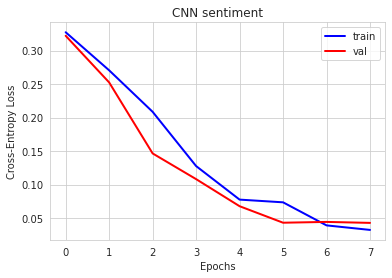

In [0]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

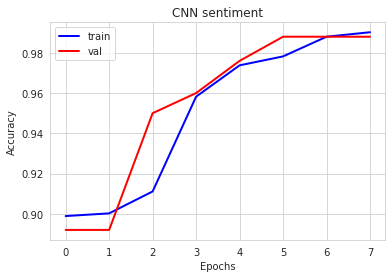

In [0]:
plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

**References:**

[1] P. Bojanowski, E. Grave, A. Joulin, T. Mikolov, "Enriching Word Vectors with Subword Information", arXiv, 2016  
[2] FastText Embeddings: https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md  
[3] F. Chollet, "Deep Learning with Python", Manning Publications, 2017  